# Import

In [1]:
# importing
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

# plotting options 
font = {'size'   : 30}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(18, 10))

# Capacity of MIMO Systems

Determining the capacity of MIMO by estimating capacity using the law of large numbers ("time averaging approximates expectation").

## Parameters

In [2]:
# number of transmit and receive antennas
# vector input --> pairwise combining
N_T = [ 1, 2, 2, 4, 4 ] 
N_R = [ 1, 2, 4, 4, 32 ]

assert len( N_T ) == len( N_R ), 'Number of transmit and receive antenna pairs has to be equal!'

# snr in dB
snr_db = np.arange( 0, 110, 10 ) 
snr = 10**( snr_db / 10 )

# number of realizations used to approximate expectation
N_real = 100

## Approximating Expectation

In [3]:
# initialize capacity array
C = np.zeros( ( len(N_T), len(snr_db) ) )

# loop for snr values
for ind_snr, val_snr in enumerate( snr ):
    
    # loop for antenna combinations
    for ind_n in np.arange( len( N_T ) ):

        # read transmit and receive antennas
        n_T = N_T[ ind_n ]
        n_R = N_R[ ind_n ]

        # instantaneous capacity; collecting along several realizations
        C_inst = []

        # loop for realizations
        for _n_real in np.arange( N_real ):

            # sample channel matrix with i.i.d. CN(0,1) entries
            H = np.matrix( 1 / np.sqrt(2) * ( np.random.randn( n_R, n_T ) + 1j * np.random.randn( n_R, n_T ) ) )

            # get matrix in "log-det formula" and determine instantaneous capacity
            # real part is applied since det(A) is always real for hermitian A (which is true in our scenario)
            det_arg = np.eye( n_R, dtype=complex ) + val_snr / n_T * H @ H.H

            C_inst.append( np.log2( np.real( np.linalg.det( det_arg ) ) ) )
        
        
        C[ ind_n, ind_snr ] = np.average( C_inst )


## Plotting Capacity


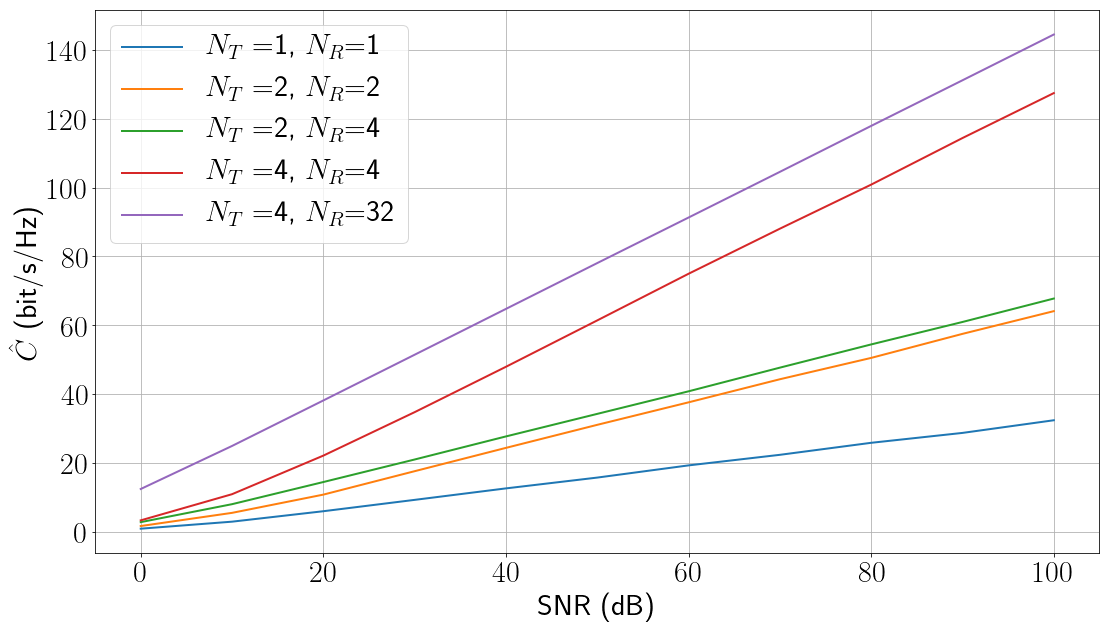

In [4]:
# combine antenna constellations
N = zip( N_T, N_R )
       
for ind_n in np.arange( len( N_T ) ):
    plt.plot( snr_db, C[ ind_n, : ], linewidth=2.0, label='$N_T=${}, $N_R$={}'.format( N_T[ind_n], N_R[ind_n] ) )
plt.xlabel( 'SNR (dB)' )
plt.ylabel( '$\\hat{C}$ (bit/s/Hz)' )

plt.grid( True )
plt.legend( loc = 'upper left' )

# Non-Zero Singular Values of MIMO Systems

The following simulation shows the number of non-zero singular values in MIMO systems.

NOTE: Values < 0.25 are assumened as equal to zero, thereby over-estimating zero singular values

## Finding Number of non-zero Singular Values

In [5]:
# specific constellation (8,8)
N_T = 8
N_R = 8

# number of realization for histogram
N_real = 1000

# deviation for counting singular values as zero
dev_sv = .25

# initialize empty array
numb_sv_collect = np.zeros( N_real )

# loop for realizations
for ind_n, val_n in enumerate( np.arange( N_real) ):

    # generate channel matrix as i.i.d. CN(0,1)
    H = np.matrix( 1 / np.sqrt( 2 ) * ( np.random.randn( N_R, N_T ) + 1j * np.random.randn( N_R, N_T ) ) )

    L, X = np.linalg.eig( np.dot( H, H.H ) )

    numb_sv_collect[ ind_n ] = np.size( np.where( np.abs( L ) > dev_sv ) )


## Plotting Histogram of non-zero Singular Values

(0.5, 8.5)

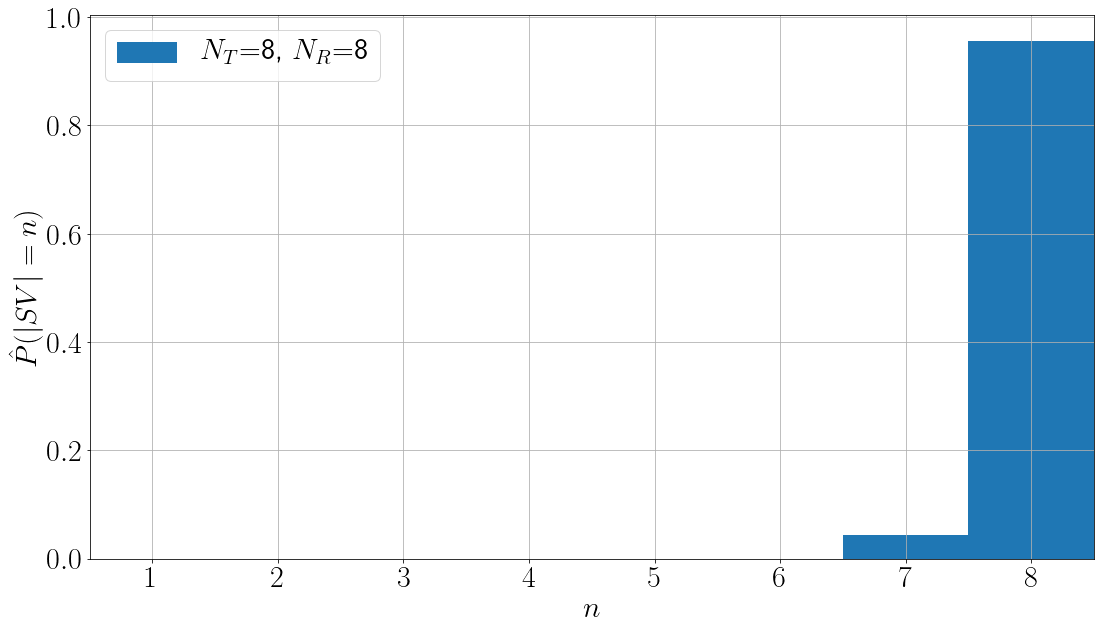

In [6]:
plt.hist( numb_sv_collect, N_T, range=[0, N_T ], normed = True, align = 'right', label='$N_{{T}}$={}, $N_{{R}}$={}'.format( N_T, N_R ) )

plt.xlabel('$n$')
plt.ylabel('$\\hat{P}(|SV|=n)$')
plt.grid()
plt.legend(loc='upper left')
plt.xlim( ( .5, N_T +.5) )

# MIMO Systems: Superpostion of Systems

Showing that, by construction, symbols are overlapping, thereby generating kind of chaotic constellation diagrams.

EXERCISE: Can you reason which values will be generated? (Hint: Use matrix-vector notation and consider r_1.)

## Showing Effects of Superposition of Symbols at the Receiver without Detection

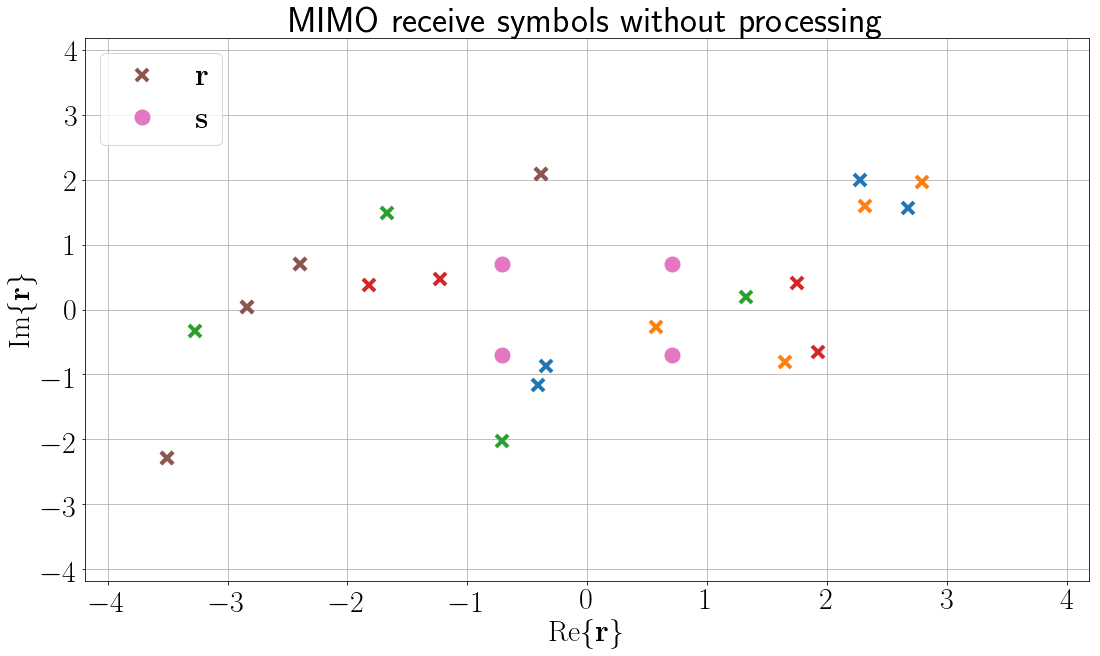

In [7]:
# snr in dB
snr_db = 20
sigma2 = 10**( - snr_db / 10 )

# specify constellation
N_T = 4
N_R = 4

# constellation using 4-qam
constellation_points = [ 1+1j, -1+1j, -1-1j, 1-1j ]
constellation_points /= np.linalg.norm( constellation_points ) / np.sqrt( len( constellation_points ) )

# number of symbols for receiver constellation diagram
N_syms_mimo = 5

# sample channel matrix as i.i.d. CN(0,1)
H = 1/np.sqrt(2) * ( np.random.randn(N_R,N_T) + 1j * np.random.randn(N_R,N_T) )

# loop for mimo symbols
for _n in np.arange( N_syms_mimo ):
    
    # sample input vector
    s = np.random.choice( constellation_points, N_T )
    
    # sampe noise vector
    noise = np.sqrt( sigma2 / 2 ) * ( np.random.randn(N_R) + 1j * np.random.randn(N_R) )

    # determine receive vector
    r = np.dot( H, s ) + noise
    
    # plot receive symbols
    plt.plot( np.real(r), np.imag(r), 'x', ms='12', mew='4')

# replot last points to apply legend
plt.plot( np.real(r), np.imag(r), 'x', ms='12', mew='4', label='$\mathbf{r}$')    
    
# plot transmit symbols for illustration
plt.plot( np.real(constellation_points), np.imag(constellation_points), 'o', ms='12', mew='4', label='$\mathbf{s}$')

plt.grid( True )
plt.xlim( (-np.max(np.abs(r)), np.max(np.abs(r))) )
plt.ylim( (-np.max(np.abs(r)), np.max(np.abs(r))) )
plt.xlabel('$\mathrm{Re}\{\mathbf{r}\}$')
plt.ylabel('$\mathrm{Im}\{\mathbf{r}\}$')    

plt.title('MIMO receive symbols without processing')
plt.legend( loc='upper left')

## Now Applying Zero-Forcing and MMSE

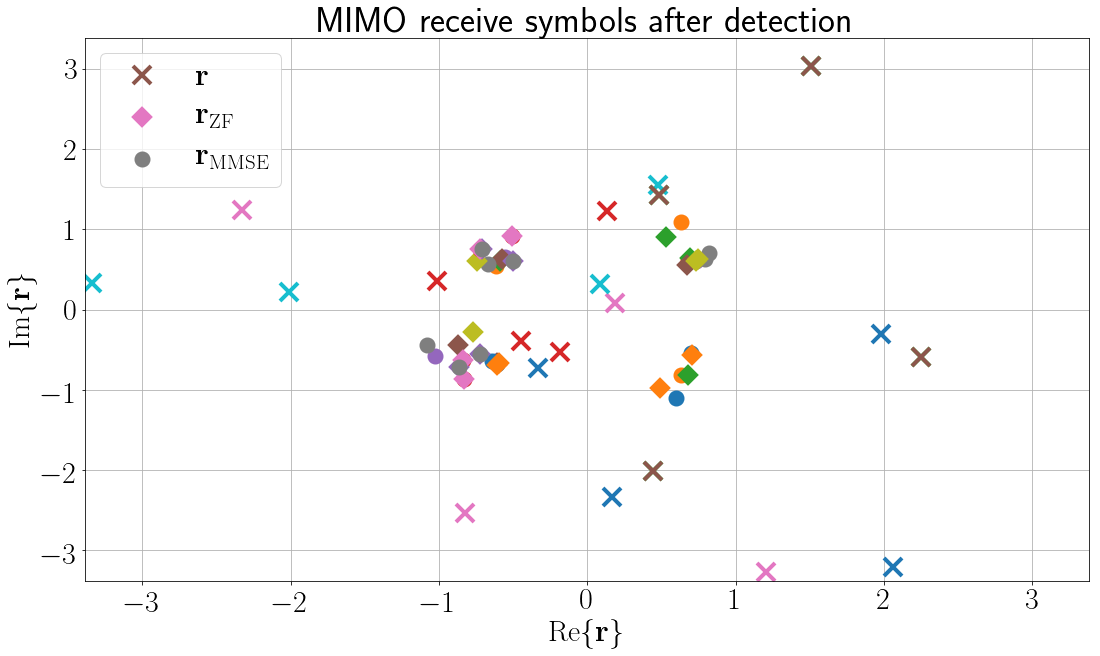

In [8]:
# get detector matrix
H = np.matrix( H )

H_zf = np.linalg.pinv( H )
H_mmse = np.linalg.pinv( H.H @ H + N_T * 10**( - snr_db / 10 ) * np.eye( N_T ) ) @ H.H


# loop for mimo symbols
for _n in np.arange( N_syms_mimo ):
    
    # sample input vector
    s = np.random.choice( constellation_points, N_T )
    
    # sampe noise vector
    noise = np.sqrt( sigma2 / 2 ) * ( np.random.randn(N_R) + 1j * np.random.randn(N_R) )

    # determine receive vector
    r = ( np.dot( H, s ) + noise ).getA1()
    
    # apply detection matrix (zero-forcing)
    y_zf = np.dot( H_zf, r ).getA1()
    y_mmse = np.dot( H_mmse, r ).getA1()
        
        
    # plot receive symbols
    plt.plot( np.real( r ), np.imag( r ), 'x', ms='18', mew='4')
    plt.plot( np.real( y_zf ), np.imag( y_zf ), 'o', ms='12', mew='4')
    plt.plot( np.real( y_mmse ), np.imag( y_mmse ), 'D', ms='12', mew='4')    



# replot last points to apply legend
plt.plot( np.real( r ), np.imag( r ), 'x', ms='18', mew='4', label='$\mathbf{r}$')    
plt.plot( np.real( y_zf ), np.imag( y_zf ), 'D', ms='12', mew='4', label='$\mathbf{r}_{{\mathrm{ZF}}}$')
plt.plot( np.real( y_mmse ), np.imag( y_mmse ), 'o', ms='12', mew='4', label='$\mathbf{r}_{{\mathrm{MMSE}}}$')

plt.grid( True )
plt.xlim( ( -np.max( np.abs( r ) ), np.max( np.abs( r ) ) ) )
plt.ylim( ( -np.max( np.abs( r ) ), np.max( np.abs( r ) ) ) )
plt.xlabel( '$\mathrm{Re}\{\mathbf{r}\}$' )
plt.ylabel( '$\mathrm{Im}\{\mathbf{r}\}$' )    

plt.title('MIMO receive symbols after detection')
plt.legend( loc = 'upper left' )
